In [65]:
# FRED API initializing
!pip install fredapi

In [66]:
# import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fredapi import Fred

In [67]:
# Authenticate
# Replace the string below with YOUR unique API key from fred.stlouisfed.org
fred = Fred(api_key='APIKEY')

In [68]:
# 1. Fetch the data series from FRED
print("Fetching data from FRED...")
wages = fred.get_series('AHETPI')
cpi = fred.get_series('CPIAUCSL')

# 2. Combine into a DF
df = pd.DataFrame({'Nominal_Wage': wages, 'CPI': cpi})

# 3. Drop missing values (The wage data starts later than CPI data)
df = df.dropna()

# Inspect the raw data
print(df.head())
print(df.tail())

Fetching data from FRED...
            Nominal_Wage    CPI
1964-01-01          2.50  30.94
1964-02-01          2.50  30.91
1964-03-01          2.51  30.94
1964-04-01          2.52  30.95
1964-05-01          2.52  30.98
            Nominal_Wage      CPI
2025-07-01         31.35  322.132
2025-08-01         31.45  323.364
2025-09-01         31.52  324.368
2025-11-01         31.73  325.031
2025-12-01         31.76  326.030


In [69]:
def get_real_wage(nominal_col, cpi_col):
  """
  Takes a nominal column and a CPI column
  Returns a new column adjusted for inflation (Real Dollars)
  """
  # 1. Get the CPI of the most recent date (Today's Price
  cpi_today = cpi_col.iloc[-1]

  # 2. The Formula: (Nominal / Old_CPI) * CPI_Today
  real_col = (nominal_col / cpi_col) * cpi_today

  return real_col

df['Real_Wage'] = get_real_wage(df['Nominal_Wage'], df['CPI'])

In [70]:
print(df.tail())

            Nominal_Wage      CPI  Real_Wage
2025-07-01         31.35  322.132  31.729355
2025-08-01         31.45  323.364  31.709292
2025-09-01         31.52  324.368  31.681502
2025-11-01         31.73  325.031  31.827524
2025-12-01         31.76  326.030  31.760000


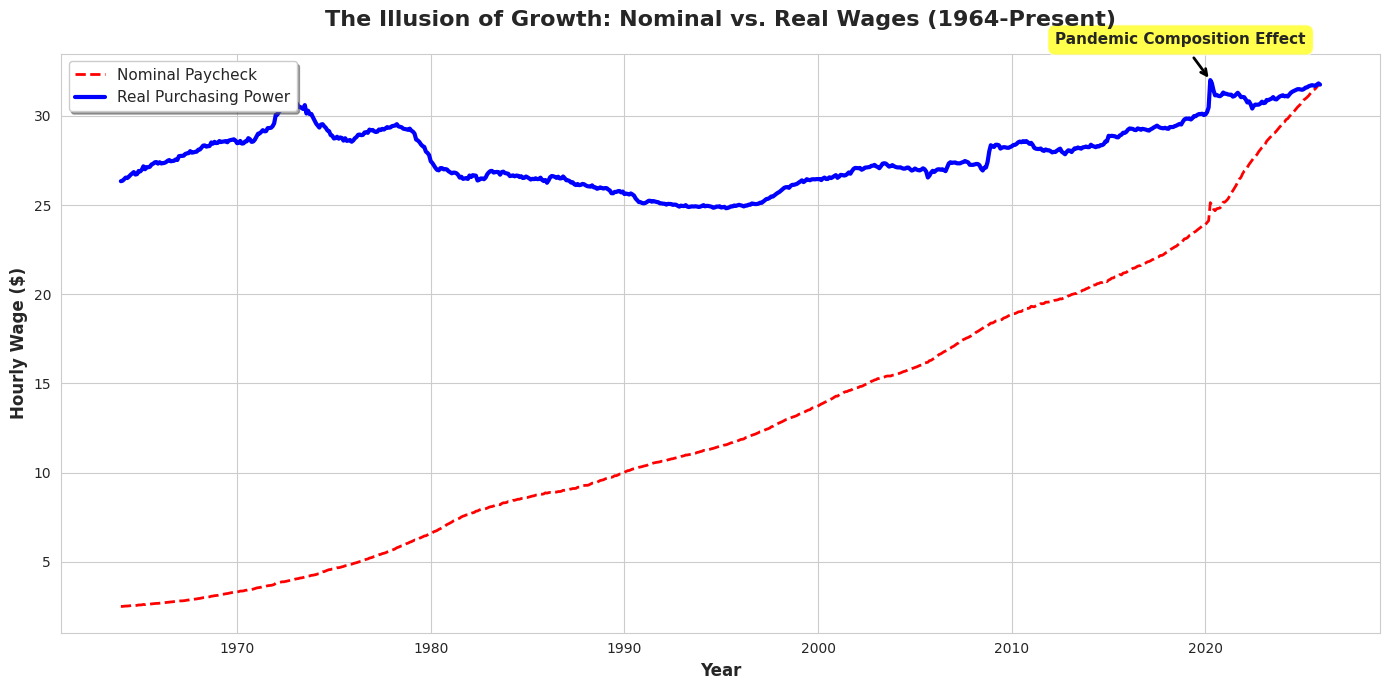

In [71]:
### Visualization

# Set the style
sns.set_style('whitegrid')

# Create figure
fig, ax = plt.subplots(figsize=(14, 7))

# Plot both lines
ax.plot(df.index, df['Nominal_Wage'],
        linestyle='--', color='red', linewidth=2,
        label='Nominal Paycheck')

ax.plot(df.index, df['Real_Wage'],
        linestyle='-', color='blue', linewidth=3,
        label='Real Purchasing Power')

# Add title and labels
ax.set_title('The Illusion of Growth: Nominal vs. Real Wages (1964-Present)',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_ylabel('Hourly Wage ($)', fontsize=12, fontweight='bold')

# Add annotation for 2020 pandemic spike
# Find the 2020 spike (peak in real wages around 2020)
pandemic_period = df.loc['2020-03':'2020-06']
spike_date = pandemic_period['Real_Wage'].idxmax()
spike_value = pandemic_period['Real_Wage'].max()

ax.annotate('Pandemic Composition Effect',
            xy=(spike_date, spike_value),
            xytext=(spike_date - pd.DateOffset(years=8), spike_value + 2),
            arrowprops=dict(arrowstyle='->', color='black', lw=2),
            fontsize=11, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))

# Add legend
ax.legend(loc='upper left', fontsize=11, frameon=True, shadow=True)

# Improve layout
plt.tight_layout()

# Display
plt.show()

Fetching ECI data from FRED...


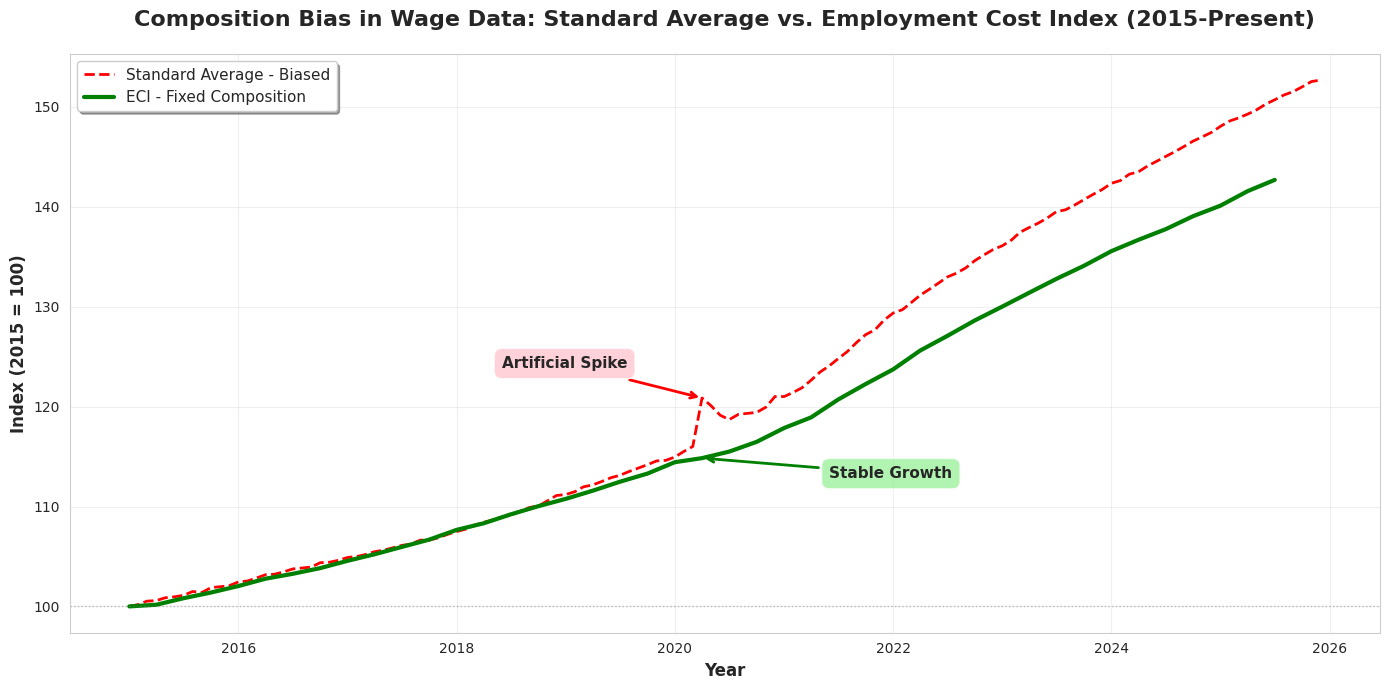


--- Summary Statistics ---
Standard Wage Growth (2015-Q2 2020): 20.87%
ECI Growth (2015-Q2 2020): 14.85%
Composition Bias at Pandemic Peak: 6.02 index points


In [72]:
# 1. Fetch the Employment Cost Index series
print("Fetching ECI data from FRED...")
eci = fred.get_series('ECIWAG')

# 2. Filter both series to 2015 onwards
wages_filtered = wages.loc['2015-01-01':]
eci_filtered = eci.loc['2015-01-01':]

# 3. Rebase both series to 100 (first value = 100)
wages_rebased = (wages_filtered / wages_filtered.iloc[0]) * 100
eci_rebased = (eci_filtered / eci_filtered.iloc[0]) * 100

# 4. Create the comparison chart
fig, ax = plt.subplots(figsize=(14, 7))

# Plot both lines
ax.plot(wages_rebased.index, wages_rebased,
        linestyle='--', color='red', linewidth=2,
        label='Standard Average - Biased')

ax.plot(eci_rebased.index, eci_rebased,
        linestyle='-', color='green', linewidth=3,
        label='ECI - Fixed Composition')

# Add title and labels
ax.set_title('Composition Bias in Wage Data: Standard Average vs. Employment Cost Index (2015-Present)',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_ylabel('Index (2015 = 100)', fontsize=12, fontweight='bold')

# 5. Add annotations for 2020 divergence
# Find the closest dates in each series to Q2 2020 (when spike occurred)
# ECI is quarterly, wages is monthly
pandemic_period = '2020-04'  # April 2020 is when the spike is most visible
pandemic_wages = wages_rebased.loc[pd.to_datetime('2020-04-01')]

# For ECI, get Q2 2020 (likely 2020-04-01 or 2020-06-01)
eci_2020_q2 = eci_rebased.loc['2020-04':'2020-06'].iloc[0]
eci_2020_q2_date = eci_rebased.loc['2020-04':'2020-06'].index[0]

# Annotate the artificial spike in standard wages
ax.annotate('Artificial Spike',
            xy=(pd.to_datetime('2020-04-01'), pandemic_wages),
            xytext=(pd.to_datetime('2018-06-01'), pandemic_wages + 3),
            arrowprops=dict(arrowstyle='->', color='red', lw=2),
            fontsize=11, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='pink', alpha=0.7))

# Annotate the stable growth in ECI
ax.annotate('Stable Growth',
            xy=(eci_2020_q2_date, eci_2020_q2),
            xytext=(pd.to_datetime('2021-06-01'), eci_2020_q2 - 2),
            arrowprops=dict(arrowstyle='->', color='green', lw=2),
            fontsize=11, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.7))

# Add horizontal line at 100 for reference
ax.axhline(y=100, color='gray', linestyle=':', linewidth=1, alpha=0.5)

# Add legend
ax.legend(loc='upper left', fontsize=11, frameon=True, shadow=True)

# Add grid
ax.grid(True, alpha=0.3)

# Improve layout
plt.tight_layout()

# Display
plt.show()

# Print summary statistics
print("\n--- Summary Statistics ---")
print(f"Standard Wage Growth (2015-Q2 2020): {pandemic_wages - 100:.2f}%")
print(f"ECI Growth (2015-Q2 2020): {eci_2020_q2 - 100:.2f}%")
print(f"Composition Bias at Pandemic Peak: {(pandemic_wages - eci_2020_q2):.2f} index points")